# CME statistics

cme_statistics.py
https://github.com/cmoestl/heliocats
analyses ICMECAT data for paper on CME statistics Moestl et al. 2020

Author: C. Moestl, IWF Graz, Austria
twitter @chrisoutofspace, https://github.com/cmoestl
last update March 2020

for installation of a conda environment to run this code, see instructions in README.md
conda dependencies are listed under environment.yml, and pip in requirements.txt

structure of this code:

1. settings

2. ICME duration vs heliocentric distance

3. Bfield 

4. time inside CMEs at each planet 

5. CME arrival frequencies

plots are saved in results/plots_stats/ as png and pdf
analysis results files are written to data/




In [1]:
from scipy import stats
import scipy.io
from matplotlib import cm
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import astropy.constants as const
from sunpy.time import parse_time
import sunpy.time
import time
import pickle
import seaborn as sns
import os
import urllib
import json
import warnings
import importlib

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#matplotlib.use('TkAgg')
#matplotlib.use('Agg')

warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings


from heliocats import stats as hs
importlib.reload(hs) #reload again while debugging


<module 'heliocats.stats' from '/home/cmoestl/pycode/heliocats/heliocats/stats.py'>

## 1. Settings



In [2]:
print('-------------------------------------------------')
print('1 SETTINGS')

### constants
#solar radius
Rs_in_AU=float(const.R_sun/const.au)


plt.close('all')
print()
print()
print('cme_statistics.py main program.')
print('ICME parameters at all 4 terrestrial planets.')
print('Christian Moestl et al., IWF Graz, Austria, last update March 2020')


########### make directories first time
resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

outputdirectory='results/plots_stats'
if os.path.isdir(outputdirectory) == False: os.mkdir(outputdirectory)


############ get basic data for times and btotal available at each mission
hs.load_url_current_directory('data/insitu_data_time_btot_moestl_2019_paper.p', \
                  'https://oeawcloud.oeaw.ac.at/index.php/s/z7nZVbH8qBjaTf5/download')
                  
#open this file
[win_time,win_btot,sta_time,sta_btot,stb_time,stb_btot, \
mav_time, mav_btot, vex_time, vex_btot, mes_time, mes_btot]= \
pickle.load(open( "data/insitu_data_time_btot_moestl_2019_paper.p", "rb" ) )
print('loaded time/Btotal data for STEREO-A/B, Wind, VEX, MESSENGER, MAVEN')


############# get positions from an IDL sav file
print('get positions')
pos = hs.getcat('data/positions_2007_2023_HEEQ_6hours.sav')
pos_time= hs.decode_array(pos.time[0:-1]) 
pos_time_num=parse_time(pos_time[0:-1]).plot_date 


########### load ICMECAT v2.0
file='icmecat/HELCATS_ICMECAT_v20.p'
print('loaded ', file)

print()
print()
print('Keys (parameters) in this pandas data frame are:')

ic=pickle.load(open(file, "rb" ) )  
print(ic.keys())
print()
print()

#get indices of events for each spacecraft
wini=np.where(ic.sc_insitu == 'Wind')[:][0] 
vexi=np.where(ic.sc_insitu == 'VEX')[:][0]  
mesi=np.where(ic.sc_insitu == 'MESSENGER')[:][0]   
stai=np.where(ic.sc_insitu == 'STEREO-A')[:][0]    
stbi=np.where(ic.sc_insitu == 'STEREO-B')[:][0]    
mavi=np.where(ic.sc_insitu == 'MAVEN')[:][0]    
ulyi=np.where(ic.sc_insitu == 'ULYSSES')[:][0]   
pspi=np.where(ic.sc_insitu == 'ParkerSolarProbe')[:][0]    
#get indices for Mercury after orbit insertion in March 2011
merci=np.where(np.logical_and(ic.sc_insitu =='MESSENGER', ic.icme_start_time > parse_time('2011-03-18').datetime))[0]



############### set limits of solar minimum, rising/declining phase and solar maximum

minstart=parse_time('2007-01-01').datetime
minend=parse_time('2009-12-31').datetime
minstart_num=parse_time('2007-01-01').plot_date
minend_num=parse_time('2009-12-31').plot_date

risestart=parse_time('2010-01-01').datetime
riseend=parse_time('2011-06-30').datetime
risestart_num=parse_time('2010-01-01').plot_date
riseend_num=parse_time('2011-06-30').plot_date

maxstart=parse_time('2011-07-01').datetime
maxend=parse_time('2014-12-31').datetime
maxstart_num=parse_time('2011-07-01').plot_date
maxend_num=parse_time('2014-12-31').plot_date

declstart=parse_time('2015-01-01').datetime
declend=parse_time('2017-12-31').datetime
declstart_num=parse_time('2015-01-01').plot_date
declend_num=parse_time('2017-12-31').plot_date


############### extract events by limits of solar min, 
############### rising, max -> too few events for MAVEN and Ulysses

#get all events for minimum
iall_min=np.where(np.logical_and(ic.icme_start_time > minstart,ic.icme_start_time < minend))[0]
iall_rise=np.where(np.logical_and(ic.icme_start_time > risestart,ic.icme_start_time < riseend))[0]
iall_max=np.where(np.logical_and(ic.icme_start_time > maxstart,ic.icme_start_time < maxend))[0]

wini_min=iall_min[np.where(ic.sc_insitu[iall_min]=='Wind')]
wini_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='Wind')]
wini_max=iall_max[np.where(ic.sc_insitu[iall_max]=='Wind')]

vexi_min=iall_min[np.where(ic.sc_insitu[iall_min]=='VEX')]
vexi_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='VEX')]
vexi_max=iall_max[np.where(ic.sc_insitu[iall_max]=='VEX')]

mesi_min=iall_min[np.where(ic.sc_insitu[iall_min]=='MESSENGER')]
mesi_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='MESSENGER')]
mesi_max=iall_max[np.where(ic.sc_insitu[iall_max]=='MESSENGER')]

stai_min=iall_min[np.where(ic.sc_insitu[iall_min]=='STEREO-A')]
stai_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='STEREO-A')]
stai_max=iall_max[np.where(ic.sc_insitu[iall_max]=='STEREO-A')]

stbi_min=iall_min[np.where(ic.sc_insitu[iall_min]=='STEREO-B')]
stbi_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='STEREO-B')]
stbi_max=iall_max[np.where(ic.sc_insitu[iall_max]=='STEREO-B')]

# select the events at Mercury extra after orbit insertion, note that no events available for solar minimum
merci_min=iall_min[np.where(np.logical_and(ic.sc_insitu[iall_min] =='MESSENGER',ic.icme_start_time[iall_min] > parse_time('2011-03-18').datetime))]
merci_rise=iall_rise[np.where(np.logical_and(ic.sc_insitu[iall_rise] =='MESSENGER',ic.icme_start_time[iall_rise] > parse_time('2011-03-18').datetime))]
merci_max=iall_max[np.where(np.logical_and(ic.sc_insitu[iall_max] =='MESSENGER',ic.icme_start_time[iall_max] > parse_time('2011-03-18').datetime))]

-------------------------------------------------
1 SETTINGS


cme_statistics.py main program.
ICME parameters at all 4 terrestrial planets.
Christian Moestl et al., IWF Graz, Austria, last update March 2020
loaded time/Btotal data for STEREO-A/B, Wind, VEX, MESSENGER, MAVEN
get positions
loaded  icmecat/HELCATS_ICMECAT_v20.p


Keys (parameters) in this pandas data frame are:
Index(['icmecat_id', 'sc_insitu', 'icme_start_time', 'mo_start_time',
       'mo_end_time', 'mo_sc_heliodistance', 'mo_sc_long_heeq',
       'mo_sc_lat_heeq', 'icme_duration', 'icme_bmax', 'icme_bmean',
       'icme_bstd', 'icme_speed_mean', 'icme_speed_std', 'mo_duration',
       'mo_bmax', 'mo_bmean', 'mo_bstd', 'mo_bzmean', 'mo_bzmin', 'mo_bzstd',
       'mo_bymean', 'mo_bystd', 'mo_speed_mean', 'mo_speed_std',
       'mo_expansion_speed', 'mo_pdyn_mean', 'mo_pdyn_std', 'mo_density_mean',
       'mo_density_std', 'mo_temperature_mean', 'mo_temperature_std',
       'sheath_pdyn_mean', 'sheath_pdyn_std'],
      d

In [3]:
ic

,icmecat_id,sc_insitu,icme_start_time,mo_start_time,mo_end_time,mo_sc_heliodistance,mo_sc_long_heeq,mo_sc_lat_heeq,icme_duration,icme_bmax,...,mo_speed_std,mo_expansion_speed,mo_pdyn_mean,mo_pdyn_std,mo_density_mean,mo_density_std,mo_temperature_mean,mo_temperature_std,sheath_pdyn_mean,sheath_pdyn_std
0,ICME_Wind_NASA_20070114_01,Wind,2007-01-14 11:31:00,2007-01-14 11:44:00,2007-01-15 07:45:00,0.9729,0.14,-4.43,20.23,14.6,...,15.5,-35.6,1.2,2.7,5.2,4.2,15652.6,9616.6,0.2,0.0
1,ICME_Wind_NASA_20070115_01,Wind,2007-01-15 20:49:00,2007-01-15 20:49:00,2007-01-16 04:45:00,0.9731,0.15,-4.57,7.93,10.4,...,28.7,-58.6,1.9,0.7,4.1,1.4,97358.1,37602.1,NaN,NaN
2,ICME_Wind_NASA_20070329_01,Wind,2007-03-29 15:04:00,2007-03-29 15:04:00,2007-03-30 00:03:00,0.9900,-0.02,-6.74,8.98,6.1,...,3.3,NaN,1.4,0.3,5.2,1.0,16707.4,8263.1,NaN,NaN
3,ICME_Wind_NASA_20070521_01,Wind,2007-05-21 22:40:00,2007-05-21 22:45:00,2007-05-22 13:25:00,1.0020,-0.23,-1.91,14.75,14.0,...,8.4,11.5,2.3,0.9,6.7,2.6,41975.6,17102.7,0.7,0.1
4,ICME_Wind_NASA_20070608_01,Wind,2007-06-08 05:45:00,2007-06-08 05:45:00,2007-06-09 05:15:00,1.0040,-0.13,0.19,23.50,9.8,...,8.4,-20.1,1.6,0.4,7.3,1.9,53830.2,25294.9,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,ICME_MAVEN_MOESTL_20170119_01,MAVEN,2017-01-19 05:50:00,2017-01-19 15:00:00,2017-01-20 18:30:00,1.4262,-91.86,4.74,36.67,5.5,...,24.6,18.7,0.5,0.2,2.6,0.8,287437.6,242820.6,0.6,0.2
673,ICME_MAVEN_MOESTL_20170703_01,MAVEN,2017-07-03 22:20:00,2017-07-04 21:00:00,2017-07-06 04:40:00,1.6225,-168.71,-2.80,54.33,7.8,...,28.6,9.2,1.3,0.5,4.8,1.4,369548.7,456549.3,0.6,0.3
674,ICME_MAVEN_MOESTL_20170722_01,MAVEN,2017-07-22 14:30:00,2017-07-22 14:30:00,2017-07-24 11:50:00,1.6368,-177.51,-3.47,45.33,6.7,...,19.4,-0.5,0.8,0.3,4.8,1.4,178292.6,220041.6,NaN,NaN
675,ICME_MAVEN_MOESTL_20170726_01,MAVEN,2017-07-26 04:30:00,2017-07-26 09:00:00,2017-07-27 12:10:00,1.6396,-179.41,-3.60,31.67,21.4,...,58.4,94.0,1.4,0.4,2.4,0.8,1167580.7,1128618.7,0.4,0.0


## 2. Duration vs distance




In [4]:

print('-------------------------------------------------')
print('2a ICME DURATION VS DISTANCE')
print()

xfit=np.linspace(0,2,1000)

#force through origin, fit with y=kx
scx=ic.mo_sc_heliodistance[:,np.newaxis]
durfit_f, _, _, _ =np.linalg.lstsq(scx,ic.icme_duration, rcond=None)

scxmin=ic.mo_sc_heliodistance[iall_min][:,np.newaxis]
durfitmin_f, _, _, _ =np.linalg.lstsq(scxmin,ic.icme_duration[iall_min],rcond=None)

scxrise=ic.mo_sc_heliodistance[iall_rise][:,np.newaxis]
durfitrise_f, _, _, _ =np.linalg.lstsq(scxrise,ic.icme_duration[iall_rise],rcond=None)

scxmax=ic.mo_sc_heliodistance[iall_max][:,np.newaxis]
durfitmax_f, _, _, _ =np.linalg.lstsq(scxmax,ic.icme_duration[iall_max],rcond=None)

#make the y axis for the fits forced through the origin
ydurfitall_f=durfit_f*xfit
ydurfitmin_f=durfitmin_f*xfit
ydurfitrise_f=durfitrise_f*xfit
ydurfitmax_f=durfitmax_f*xfit

-------------------------------------------------
2a ICME DURATION VS DISTANCE




linear fit results, hours vs AU
overall:    D[h]=29.93 R[AU] 
minimum:    D[h]=22.39 R[AU] 
rise phase: D[h]=27.23 R[AU]
maximum:    D[h]=33.65 R[AU]

2b ICME DURATION VS TIME




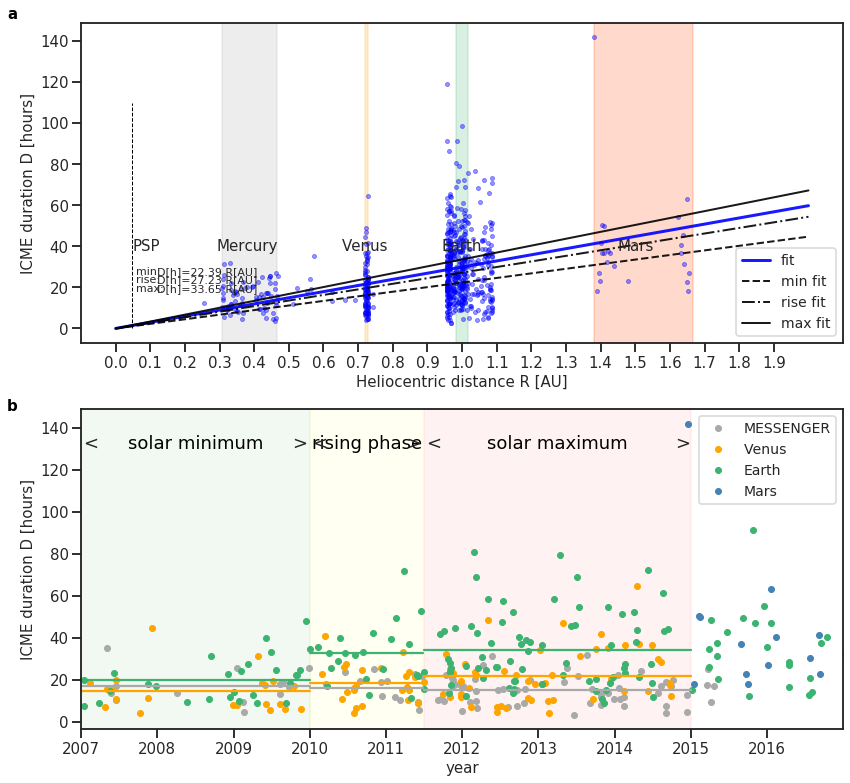

<Figure size 432x288 with 0 Axes>

In [5]:

sns.set_context("talk")                
#sns.set_style("darkgrid")  
sns.set_style("ticks",{'grid.linestyle': '--'})

fig=plt.figure(1,figsize=(12,11	))
fsize=15
ax1 = plt.subplot2grid((2,1), (0, 0))
#x axis

plt.plot(ic.mo_sc_heliodistance,ic.icme_duration,'o',color='blue',markersize=4, alpha=0.4)
#for plotting min/rise/max differently
#plt.plot(sc_heliodistance[iall_min],icme_durations[iall_min],'o',color='dimgre',markersize=3, alpha=0.4,label='D min')
#plt.plot(sc_heliodistance[iall_rise],icme_durations[iall_rise],'o',color='grey',markersize=3, alpha=0.7,label='D rise')
#plt.plot(sc_heliodistance[iall_max],icme_durations[iall_max],'o',color='black',markersize=3, alpha=0.8,label='D max')

#plot fits
plt.plot(xfit,ydurfitall_f,'-',color='blue', lw=3, alpha=0.9,label='fit')
plt.plot(xfit,ydurfitmin_f,'--',color='black', lw=2, alpha=0.9,label='min fit')
plt.plot(xfit,ydurfitrise_f,'-.',color='black', lw=2, alpha=0.9,label='rise fit')
plt.plot(xfit,ydurfitmax_f,'-',color='black', lw=2, alpha=0.9,label='max fit')

print()
print('linear fit results, hours vs AU')	
print('overall:    D[h]={:.2f} R[AU] '.format(durfit_f[0]))
print('minimum:    D[h]={:.2f} R[AU] '.format(durfitmin_f[0]))
print('rise phase: D[h]={:.2f} R[AU]'.format(durfitrise_f[0]))
print('maximum:    D[h]={:.2f} R[AU]'.format(durfitmax_f[0]))

label_level=85
label_level=30

#plt.annotate('overall:',xy=(0.06,label_level),fontsize=11)
#plt.annotate('D[h]={:.2f} R[AU]'.format(durfit_f[0]),xy=(0.15,label_level),fontsize=11)
plt.annotate('min:',xy=(0.06,label_level-4),fontsize=11) 
plt.annotate('D[h]={:.2f} R[AU] '.format(durfitmin_f[0]),xy=(0.12,label_level-4),fontsize=11)
plt.annotate('rise:',xy=(0.06,label_level-8),fontsize=11) 
plt.annotate('D[h]={:.2f} R[AU]'.format(durfitrise_f[0]),xy=(0.12,label_level-8),fontsize=11)
plt.annotate('max:',xy=(0.06,label_level-12),fontsize=11)    
plt.annotate('D[h]={:.2f} R[AU]'.format(durfitmax_f[0]),xy=(0.12,label_level-12),fontsize=11)

#planet limits
plt.axvspan(np.min(pos.mars[0]),np.max(pos.mars[0]), color='orangered', alpha=0.2)
plt.axvspan(np.min(pos.mercury[0]),np.max(pos.mercury[0]), color='darkgrey', alpha=0.2)
plt.axvspan(np.min(pos.venus[0]),np.max(pos.venus[0]), color='orange', alpha=0.2)
plt.axvspan(np.min(pos.earth[0]),np.max(pos.earth[0]), color='mediumseagreen', alpha=0.2)
#plt.axvspan(np.min(pos.sta[0]),np.max(pos.sta[0]), color='red', alpha=0.2)  #STEREO-A
#plt.axvspan(np.min(pos.stb[0]),np.max(pos.stb[0]), color='blue', alpha=0.2)  #STEREO-B
#Parker Probe minimum
plt.plot([0.046,0.046],[0,110], color='black', linestyle='--', linewidth=1)

#label_level=100
label_level=38

plt.annotate('Mars', xy=(1.5,label_level), ha='center',fontsize=fsize)
plt.annotate('Mercury', xy=(0.38,label_level), ha='center',fontsize=fsize)
plt.annotate('Venus', xy=(0.72,label_level), ha='center',fontsize=fsize)
plt.annotate('Earth', xy=(1,label_level), ha='center',fontsize=fsize)
plt.annotate('PSP', xy=(0.05,label_level), ha='left',fontsize=fsize)

#for PSP zoom
#plt.xlim(0,1.2)
#plt.ylim(0,40)

ax1.set_xticks(np.arange(0,2,0.1))
#plt.xlim(0,max(sc_heliodistance)+0.3)
#plt.ylim(0,110)

plt.legend(loc=4,fontsize=fsize-1)
plt.xlabel('Heliocentric distance R [AU]',fontsize=fsize)
plt.ylabel('ICME duration D [hours]',fontsize=fsize)
plt.yticks(fontsize=fsize) 
plt.xticks(fontsize=fsize) 
#plt.grid()







##################### (2b) ICME DURATION VS TIME ########################################


print('')
print('2b ICME DURATION VS TIME')
print()
print()

'''
tests for gaussians and Hathaway's function for solar cycle, not used
Wind
tfit=mdates.date2num(sunpy.time.parse_time('2009-04-01'))+np.arange(0,365*10)
t0=mdates.date2num(sunpy.time.parse_time('2009-01-01'))

Gaussian
sigma=1000
bfitmax=30
mu=mdates.date2num(sunpy.time.parse_time('2013-01-01'))
ygauss=1/(sigma*np.sqrt(2*np.pi))*np.exp(-((xfit-mu)**2)/(2*sigma**2) )
normalize with 1/max(ygauss)
plt.plot_date(xfit, ygauss*1/max(ygauss)*bfitmax,'o',color='mediumseagreen',linestyle='-',markersize=0, label='Earth fit')

Hathaway 2015 equation 6 page 40
average cycle sunspot number 
A=100 amplitude 195 for sunspot
b=100*12 56*12 for months to days
c=0.8
4 free parameters A, b, c, t0

Fwind=A*(((tfit-t0)/b)**3) * 1/(np.exp((((tfit-t0)/b)**2))-c)
plt.plot_date(tfit, Fwind,'o',color='mediumseagreen',linestyle='-',markersize=0, label='Earth fit')

xaxis: 10 years, daily data point
xfit2=mdates.date2num(sunpy.time.parse_time('2007-01-01'))+np.arange(0,365*10)
MESSENGER
sigma=1000
bfitmax=10
mu=mdates.date2num(sunpy.time.parse_time('2013-01-01'))
ygauss=1/(sigma*np.sqrt(2*np.pi))*np.exp(-((xfit2-mu)**2)/(2*sigma**2) )
normalize with 1/max(ygauss)
plt.plot_date(xfit, ygauss*1/max(ygauss)*bfitmax,'o',color='darkgrey',linestyle='-',markersize=0, label='Mercury fit')

VEX
inital guess
sigma=1000
bfitmax=20
mu=mdates.date2num(sunpy.time.parse_time('2013-01-01'))
ygauss=1/(sigma*np.sqrt(2*np.pi))*np.exp(-((xfit2-mu)**2)/(2*sigma**2) )
normalize with 1/max(ygauss)
plt.plot_date(xfit2, ygauss*1/max(ygauss)*bfitmax,'o',color='orange',linestyle='-',markersize=0, label='Venus fit')

for Mars: reconstruct likely parameters if sigma is quite similar for all fits, take mean of those sigmas and adjust bfitmax as function of distance with power law)
plot reconstructed function for Mars
bfitmax=40
plt.plot_date(xfit2, Fwind,'o',color='steelblue',linestyle='--',markersize=0, label='Mars reconstr.')
'''



#################################### plot 

ax2 = plt.subplot2grid((2,1), (1, 0))
markers=6
linew=0

#plot durations for all planets
ax2.plot_date(ic.icme_start_time[mesi],ic.icme_duration[mesi], \
    'o',color='darkgrey',markersize=markers,linestyle='-',linewidth=linew,label='MESSENGER')
ax2.plot_date(ic.icme_start_time[vexi],ic.icme_duration[vexi], \
    'o',color='orange',markersize=markers,linestyle='-',linewidth=linew, label='Venus')
ax2.plot_date(ic.icme_start_time[wini],ic.icme_duration[wini], \
    'o',color='mediumseagreen',markersize=markers, linestyle='-', linewidth=linew, label='Earth')
ax2.plot_date(ic.icme_start_time[mavi],ic.icme_duration[mavi], \
    'o',color='steelblue',markersize=markers,linestyle='-',linewidth=linew, label='Mars')


#limits solar min/rise/maxax2.set_ylim(0,80)
vlevel=130
spanalpha=0.05

plt.axvspan(minstart,minend, color='green', alpha=spanalpha)
plt.annotate('solar minimum',xy=(minstart_num+(minend_num-minstart_num)/2,vlevel),color='black', ha='center')
plt.annotate('<',xy=(minstart_num+10,vlevel),ha='left')
plt.annotate('>',xy=(minend_num-10,vlevel),ha='right')

plt.axvspan(risestart,riseend, color='yellow', alpha=spanalpha)
plt.annotate('rising phase',xy=(risestart_num+(riseend_num-risestart_num)/2,vlevel),color='black', ha='center')
plt.annotate('<',xy=(risestart_num+10,vlevel),ha='left')
plt.annotate('>',xy=(riseend_num-10,vlevel),ha='right')

plt.axvspan(maxstart,maxend, color='red', alpha=spanalpha)
plt.annotate('solar maximum',xy=(maxstart_num+(maxend_num-maxstart_num)/2,vlevel),color='black', ha='center')
plt.annotate('<',xy=(maxstart_num+10,vlevel),ha='left')
plt.annotate('>',xy=(maxend_num,vlevel),ha='right')


#plot means as horizontal lines for each sub interval
plt.plot_date( [minstart,minend], [np.mean(ic.icme_duration[wini_min]),np.mean(ic.icme_duration[wini_min])], color='mediumseagreen', linestyle='-',markersize=0 ) 
plt.plot_date( [minstart,minend], [np.mean(ic.icme_duration[vexi_min]),np.mean(ic.icme_duration[vexi_min])], color='orange', linestyle='-', markersize=0) 
plt.plot_date( [minstart,minend], [np.mean(ic.icme_duration[mesi_min]),np.mean(ic.icme_duration[mesi_min])], color='darkgrey', linestyle='-', markersize=0) 

plt.plot_date( [risestart,riseend], [np.mean(ic.icme_duration[wini_rise]),np.mean(ic.icme_duration[wini_rise])], color='mediumseagreen', linestyle='-',markersize=0 ) 
plt.plot_date( [risestart,riseend], [np.mean(ic.icme_duration[vexi_rise]),np.mean(ic.icme_duration[vexi_rise])], color='orange', linestyle='-', markersize=0) 
plt.plot_date( [risestart,riseend], [np.mean(ic.icme_duration[mesi_rise]),np.mean(ic.icme_duration[mesi_rise])], color='darkgrey', linestyle='-', markersize=0) 

plt.plot_date( [maxstart,maxend], [np.mean(ic.icme_duration[wini_max]),np.mean(ic.icme_duration[wini_max])], color='mediumseagreen', linestyle='-',markersize=0 ) 
plt.plot_date( [maxstart,maxend], [np.mean(ic.icme_duration[vexi_max]),np.mean(ic.icme_duration[vexi_max])], color='orange', linestyle='-', markersize=0) 
plt.plot_date( [maxstart,maxend], [np.mean(ic.icme_duration[mesi_max]),np.mean(ic.icme_duration[mesi_max])], color='darkgrey', linestyle='-', markersize=0) 

plt.xlim(sunpy.time.parse_time('2007-01-01').datetime, sunpy.time.parse_time('2016-12-31').datetime)
plt.ylabel('ICME duration D [hours]',fontsize=fsize)
plt.xlabel('year',fontsize=fsize)
plt.tight_layout()
plt.yticks(fontsize=fsize) 
plt.xticks(fontsize=fsize) 
plt.legend(loc=1,fontsize=fsize-1)

#panel labels
plt.figtext(0.01,0.98,'a',color='black', fontsize=fsize, ha='left',fontweight='bold')
plt.figtext(0.01,0.485,'b',color='black', fontsize=fsize, ha='left',fontweight='bold')

plt.show()
plt.savefig('results/plots_stats/icme_duration_distance_time_paper.pdf', dpi=300)
plt.savefig('results/plots_stats/icme_duration_distance_time_paper.png', dpi=300)


## 3. Bfield vs distance

In [6]:

# xfit starts here at 1 Rs  because there should not be a 0 in xfit ** bmaxfit[0] later	
xfit=np.linspace(Rs_in_AU,2,1000)

print('Fit results for B in Form: y=B0*x^k')
####### power law fits for all events
bmaxfit=np.polyfit(np.log10(ic.mo_sc_heliodistance),np.log10(ic.mo_bmax),1)
b=10**bmaxfit[1]
bmaxfitfun=b*(xfit**bmaxfit[0])
print('bmax:       ',round(10**bmaxfit[1],2),' x ^', round(bmaxfit[0],2))

bmeanfit=np.polyfit(np.log10(ic.mo_sc_heliodistance),np.log10(ic.mo_bmean),1)
b=10**bmeanfit[1]
bmeanfitfun=b*(xfit**bmeanfit[0])
print('bmean:      ', round(10**bmeanfit[1],2),' x ^',round(bmeanfit[0],2))

##fit with only minimum events
bmeanfit_min=np.polyfit(np.log10(ic.mo_sc_heliodistance[iall_min]),np.log10(ic.mo_bmean[iall_min]),1)
bmeanfitfun_min=(10**bmeanfit_min[1])*(xfit**bmeanfit_min[0])
print('bmean_min:  ', round(10**bmeanfit_min[1],2),' x ^', round(bmeanfit_min[0],2))

##fit with only rising events
bmeanfit_rise=np.polyfit(np.log10(ic.mo_sc_heliodistance[iall_rise]),np.log10(ic.mo_bmean[iall_rise]),1)
bmeanfitfun_rise=(10**bmeanfit_rise[1])*(xfit**bmeanfit_rise[0])
print('bmean_rise: ', round(10**bmeanfit_rise[1],2),' x ^', round(bmeanfit_rise[0],2))

##fit with only maximum events
bmeanfit_max=np.polyfit(np.log10(ic.mo_sc_heliodistance[iall_max]),np.log10(ic.mo_bmean[iall_max]),1)
bmeanfitfun_max=(10**bmeanfit_max[1])*(xfit**bmeanfit_max[0])
print('bmean_max:  ', round(10**bmeanfit_max[1],2),' x ^',round(bmeanfit_max[0],2))


Fit results for B in Form: y=B0*x^k
bmax:        12.54  x ^ -1.7
bmean:       9.0  x ^ -1.66
bmean_min:   8.32  x ^ -1.28
bmean_rise:  9.01  x ^ -1.73
bmean_max:   8.8  x ^ -1.8



bmean_sun:   8.98  x ^ -1.69
bmax_sun:    12.53  x ^ -1.71


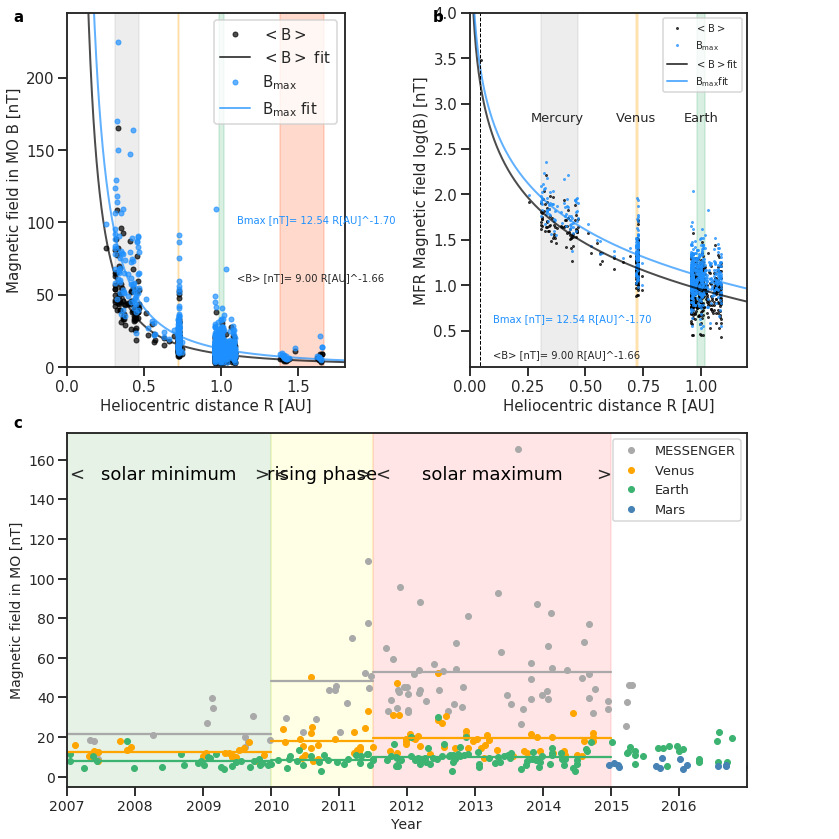

In [7]:

sns.set_context("talk")     
sns.set_style("ticks",{'grid.linestyle': '--'})
fig=plt.figure(2,figsize=(12,12	))
fsize=15
ax1 = plt.subplot2grid((2,2), (0, 0))


################# plots 3a
plt.plot(ic.mo_sc_heliodistance,ic.mo_bmean,'o',color='black',markersize=5, alpha=0.7,label='$\mathregular{<B>}$')
plt.plot(xfit,bmeanfitfun,'-',color='black', lw=2, alpha=0.7,label='$\mathregular{<B> \\ fit}$')

plt.plot(ic.mo_sc_heliodistance,ic.mo_bmax,'o',color='dodgerblue',markersize=5, alpha=0.7,label='$\mathregular{B_{max}}$')
plt.plot(xfit,bmaxfitfun,'-',color='dodgerblue', lw=2, alpha=0.7,label='$\mathregular{B_{max} \\ fit}$')

#plt.text(1.1,120,'$\mathregular{<B> [nT]= {:.2f} R[AU]^{{:.2f}}}$'.format(10**bmeanfit[1],bmeanfit[0]), fontsize=10)
plt.text(1.1,60,r'<B> [nT]= {:.2f} R[AU]^{:.2f}'.format(10**bmeanfit[1],bmeanfit[0]), fontsize=10)
plt.text(1.1,100,r'Bmax [nT]= {:.2f} R[AU]^{:.2f}'.format(10**bmaxfit[1],bmaxfit[0]), fontsize=10,color='dodgerblue')

#planet limits
plt.axvspan(np.min(pos.mars[0]),np.max(pos.mars[0]), color='orangered', alpha=0.2)
#plt.figtext(0.8,0.8,'Mars',color='orangered')
plt.axvspan(np.min(pos.mercury[0]),np.max(pos.mercury[0]), color='darkgrey', alpha=0.2)
#plt.figtext(0.25,0.8,'Mercury',color='darkgrey')
plt.axvspan(np.min(pos.venus[0]),np.max(pos.venus[0]), color='orange', alpha=0.2)
#plt.figtext(0.42,0.8,'Venus',color='orange')
plt.axvspan(np.min(pos.earth[0]),np.max(pos.earth[0]), color='mediumseagreen', alpha=0.2)
#plt.figtext(0.6,0.8,'Earth',color='mediumseagreen')

#plt.figtext(0.65,0.2,' D[h]={:.2f} R[AU] + {:.2f}'.format(durfit[0],durfit[1]))
plt.xlim(0,1.8)
plt.ylim(0,max(ic.mo_bmax)+20)

plt.legend(loc=1,fontsize=fsize)

plt.xlabel('Heliocentric distance R [AU]',fontsize=fsize)
plt.ylabel('Magnetic field in MO B [nT]',fontsize=fsize)
plt.yticks(fontsize=fsize) 
plt.xticks(fontsize=fsize) 
#plt.grid()




######################## 3b logarithmic plot with Sun

#for the bmean fit, append one value for the coronal field 
#patsourakos georgoulis 2016: 0.03 G for 10 Rs #10^5 nT is 1 Gauss
ic.mo_bmean_sun=np.append(ic.mo_bmean,10**5*0.03) 
ic.mo_bmax_sun=np.append(ic.mo_bmax,10**5*0.03) 
ic.mo_sc_heliodistance_sun=np.append(ic.mo_sc_heliodistance,10*Rs_in_AU)

print()
bmeanfit_sun=np.polyfit(np.log10(ic.mo_sc_heliodistance_sun),np.log10(ic.mo_bmean_sun),1)
b=10**bmeanfit_sun[1]
bmeanfitfun_sun=b*(xfit**bmeanfit_sun[0])
print('bmean_sun:  ', round(10**bmeanfit_sun[1],2),' x ^',round(bmeanfit_sun[0],2))

bmaxfit_sun=np.polyfit(np.log10(ic.mo_sc_heliodistance_sun),np.log10(ic.mo_bmax_sun),1)
b=10**bmaxfit_sun[1]
bmaxfitfun_sun=b*(xfit**bmaxfit_sun[0])
print('bmax_sun:   ', round(10**bmaxfit_sun[1],2),' x ^',round(bmaxfit_sun[0],2))


ax3 = plt.subplot2grid((2,2), (0, 1))

plt.plot(ic.mo_sc_heliodistance_sun,np.log10(ic.mo_bmean_sun),'o',color='black',markersize=2, alpha=0.7,label='$\mathregular{<B>}$')
plt.plot(ic.mo_sc_heliodistance,np.log10(ic.mo_bmax),'o',color='dodgerblue',markersize=2, alpha=0.7,label='$\mathregular{B_{max}}$')
plt.plot(xfit,np.log10(bmeanfitfun_sun),'-',color='black', lw=2, alpha=0.7,label='$\mathregular{<B> fit}$')
plt.plot(xfit,np.log10(bmaxfitfun_sun),'-',color='dodgerblue', lw=2, alpha=0.7,label='$\mathregular{B_{max} fit}$')
plt.ylim(0.1,4)


#Planet labels and shades
ax3.annotate('Mars', xy=(1.5,2.8), ha='center',fontsize=fsize-2)
ax3.annotate('Mercury', xy=(0.38,2.8), ha='center',fontsize=fsize-2)
ax3.annotate('Venus', xy=(0.72,2.8), ha='center',fontsize=fsize-2)
ax3.annotate('Earth', xy=(1,2.8), ha='center',fontsize=fsize-2)
plt.plot([0.046,0.046],[0,10], color='black', linestyle='--', linewidth=1)

plt.axvspan(np.min(pos.mars[0]),np.max(pos.mars[0]), color='orangered', alpha=0.2)
plt.axvspan(np.min(pos.mercury[0]),np.max(pos.mercury[0]), color='darkgrey', alpha=0.2)
plt.axvspan(np.min(pos.venus[0]),np.max(pos.venus[0]), color='orange', alpha=0.2)
plt.axvspan(np.min(pos.earth[0]),np.max(pos.earth[0]), color='mediumseagreen', alpha=0.2)
#plt.xlim(0,1.8)
#PSP
plt.xlim(0,1.2)

plt.text(0.1,0.2,r'<B> [nT]= {:.2f} R[AU]^{:.2f}'.format(10**bmeanfit[1],bmeanfit[0]), fontsize=10)
plt.text(0.1,0.6,r'Bmax [nT]= {:.2f} R[AU]^{:.2f}'.format(10**bmaxfit[1],bmaxfit[0]), fontsize=10,color='dodgerblue')

plt.legend(loc=1,fontsize=fsize-5)

plt.xlabel('Heliocentric distance R [AU]',fontsize=fsize)
plt.ylabel('MFR Magnetic field log(B) [nT]',fontsize=fsize)
plt.yticks(fontsize=fsize) 
plt.xticks(fontsize=fsize) 


#panel labels
plt.figtext(0.03,0.96,'a',color='black', fontsize=fsize, ha='left',fontweight='bold')
plt.figtext(0.515,0.96,'b',color='black', fontsize=fsize, ha='left',fontweight='bold')
plt.figtext(0.03,0.49,'c',color='black', fontsize=fsize, ha='left',fontweight='bold')


#plt.text(1.1,60,r'<B> [nT]= {:.2f} R[AU]^{:.2f}'.format(10**bmeanfit[1],bmeanfit[0]), fontsize=10)
#plt.text(1.1,100,r'Bmax [nT]= {:.2f} R[AU]^{:.2f}'.format(10**bmaxfit[1],bmaxfit[0]), fontsize=10,color='dodgerblue')



################################# 3c MO B vs. time
ax2 = plt.subplot2grid((2,2), (1, 0), colspan=2)
markers=6
linew=0
plt.plot_date(ic.icme_start_time[mesi],ic.mo_bmean[mesi],'o',color='darkgrey',markersize=markers,linestyle='-',linewidth=linew,label='MESSENGER')
plt.plot_date(ic.icme_start_time[vexi],ic.mo_bmean[vexi],'o',color='orange',markersize=markers,linestyle='-',linewidth=linew, label='Venus')
plt.plot_date(ic.icme_start_time[wini],ic.mo_bmean[wini],'o',color='mediumseagreen',markersize=markers, linestyle='-', linewidth=linew, label='Earth')
plt.plot_date(ic.icme_start_time[mavi],ic.mo_bmean[mavi],'o',color='steelblue',markersize=markers,linestyle='-',linewidth=linew, label='Mars')

'''
NOT USED:
add gaussian fits for MESSENGER, VEX, Wind (MAVEN too few data points)
instead of gaussian, fit solar cycle functions in Hathaway 2015 solar cycle living reviews equation 6
xaxis: 10 years, daily data point
xfit=mdates.date2num(sunpy.time.parse_time('2007-01-01'))+np.arange(0,365*10)
MESSENGER
sigma=1000
bfitmax=80
mu=mdates.date2num(sunpy.time.parse_time('2013-01-01'))
ygauss=1/(sigma*np.sqrt(2*np.pi))*np.exp(-((xfit-mu)**2)/(2*sigma**2) )
normalize with 1/max(ygauss)
plt.plot_date(xfit, ygauss*1/max(ygauss)*bfitmax,'o',color='darkgrey',linestyle='-',markersize=0, label='Mercury fit')
VEX
inital guess
sigma=1000
bfitmax=40
mu=mdates.date2num(sunpy.time.parse_time('2013-01-01'))
ygauss=1/(sigma*np.sqrt(2*np.pi))*np.exp(-((xfit-mu)**2)/(2*sigma**2) )
normalize with 1/max(ygauss)
plt.plot_date(xfit, ygauss*1/max(ygauss)*bfitmax,'o',color='orange',linestyle='-',markersize=0, label='Venus fit')
Wind
sigma=1000
bfitmax=10
mu=mdates.date2num(sunpy.time.parse_time('2013-01-01'))
ygauss=1/(sigma*np.sqrt(2*np.pi))*np.exp(-((xfit-mu)**2)/(2*sigma**2) )
normalize with 1/max(ygauss)
plt.plot_date(xfit, ygauss*1/max(ygauss)*bfitmax,'o',color='mediumseagreen',linestyle='-',markersize=0, label='Earth fit')
for Mars: reconstruct likely parameters if sigma is quite similar for all fits, take mean of those sigmas and adjust bfitmax as function of distance with power law)
plot reconstructed function for Mars
bfitmax=6
plt.plot_date(xfit, ygauss*1/max(ygauss)*bfitmax,'o',color='steelblue',linestyle='--',markersize=0, label='Mars reconstr.')
'''


plt.legend(loc=1,fontsize=fsize-2)

#limits solar min/rise/max

vlevel=150

plt.axvspan(minstart,minend, color='green', alpha=0.1)
plt.annotate('solar minimum',xy=(minstart+(minend-minstart)/2,vlevel),color='black', ha='center')
plt.annotate('<',xy=(mdates.date2num(minstart)+10,vlevel),ha='left')
plt.annotate('>',xy=(mdates.date2num(minend)-10,vlevel),ha='right')

plt.axvspan(risestart,riseend, color='yellow', alpha=0.1)
plt.annotate('rising phase',xy=(risestart+(riseend-risestart)/2,vlevel),color='black', ha='center')
plt.annotate('<',xy=(mdates.date2num(risestart)+10,vlevel),ha='left')
plt.annotate('>',xy=(mdates.date2num(riseend)-10,vlevel),ha='right')

plt.axvspan(maxstart,maxend, color='red', alpha=0.1)
plt.annotate('solar maximum',xy=(maxstart+(maxend-maxstart)/2,vlevel),color='black', ha='center')
plt.annotate('<',xy=(mdates.date2num(maxstart)+10,vlevel),ha='left')
plt.annotate('>',xy=(mdates.date2num(maxend),vlevel),ha='right')


plt.plot_date( [minstart,minend], [np.mean(ic.mo_bmean[wini_min]), \
               np.mean(ic.mo_bmean[wini_min])], color='mediumseagreen', linestyle='-',markersize=0 ) 
plt.plot_date( [minstart,minend], [np.mean(ic.mo_bmean[vexi_min]), \
               np.mean(ic.mo_bmean[vexi_min])], color='orange', linestyle='-', markersize=0) 
plt.plot_date( [minstart,minend], [np.mean(ic.mo_bmean[mesi_min]), \
               np.mean(ic.mo_bmean[mesi_min])], color='darkgrey', linestyle='-', markersize=0) 

plt.plot_date( [risestart,riseend], [np.mean(ic.mo_bmean[wini_rise]), \
               np.mean(ic.mo_bmean[wini_rise])], color='mediumseagreen', linestyle='-',markersize=0 ) 
plt.plot_date( [risestart,riseend], [np.mean(ic.mo_bmean[vexi_rise]), \
               np.mean(ic.mo_bmean[vexi_rise])], color='orange', linestyle='-', markersize=0) 
plt.plot_date( [risestart,riseend], [np.mean(ic.mo_bmean[mesi_rise]), \
               np.mean(ic.mo_bmean[mesi_rise])], color='darkgrey', linestyle='-', markersize=0) 

plt.plot_date( [maxstart,maxend], [np.mean(ic.mo_bmean[wini_max]), \
               np.mean(ic.mo_bmean[wini_max])], color='mediumseagreen', linestyle='-',markersize=0 ) 
plt.plot_date( [maxstart,maxend], [np.mean(ic.mo_bmean[vexi_max]), \
               np.mean(ic.mo_bmean[vexi_max])], color='orange', linestyle='-', markersize=0) 
plt.plot_date( [maxstart,maxend], [np.mean(ic.mo_bmean[mesi_max]), \
               np.mean(ic.mo_bmean[mesi_max])], color='darkgrey', linestyle='-', markersize=0) 

plt.ylabel('Magnetic field in MO [nT]', fontsize=fsize)
plt.xlabel('Year', fontsize=fsize)
fsize=14
plt.xlim(parse_time('2007-01-01').datetime, parse_time('2016-12-31').datetime)

plt.ylabel('Magnetic field in MO [nT]', fontsize=fsize)
plt.xlabel('Year', fontsize=fsize)
plt.tight_layout()
plt.yticks(fontsize=fsize) 
plt.xticks(fontsize=fsize) 
plt.legend(loc=1,fontsize=fsize-1)

plt.tight_layout()
plt.savefig('results/plots_stats/icme_total_field_distance_time_paper.pdf', dpi=300)
plt.savefig('results/plots_stats/icme_total_field_distance_time_paper.png', dpi=300)


In [21]:
########################### RESULTS Bfield

print()
print()

print('Magnetic field B ic.mo_bmean results, mean +/- std [nT]')

print()
print('Mercury ', round(np.mean(ic.mo_bmean[merci]),1),' +/- ', round(np.std(ic.mo_bmean[merci]),1))
#print('min     ', round(np.mean(ic.mo_bmean[merci_min]),1), ' +/- ', round(np.std(ic.mo_bmean[merci_min]),1))
print('min      no events')
print('rise    ', round(np.mean(ic.mo_bmean[merci_rise]),1), ' +/- ', round(np.std(ic.mo_bmean[merci_rise]),1))
print('max     ', round(np.mean(ic.mo_bmean[merci_max]),1), ' +/- ', round(np.std(ic.mo_bmean[merci_max]),1))

print()
print('Venus   ', round(np.mean(ic.mo_bmean[vexi]),1),' +/- ', round(np.std(ic.mo_bmean[vexi]),1))
print('min     ', round(np.mean(ic.mo_bmean[vexi_min]),1), ' +/- ', round(np.std(ic.mo_bmean[vexi_min]),1))
print('rise    ', round(np.mean(ic.mo_bmean[vexi_rise]),1), ' +/- ', round(np.std(ic.mo_bmean[vexi_rise]),1))
print('max     ', round(np.mean(ic.mo_bmean[vexi_max]),1), ' +/- ', round(np.std(ic.mo_bmean[vexi_max]),1))

print()
print('Earth   ', round(np.mean(ic.mo_bmean[wini]),1),' +/- ', round(np.std(ic.mo_bmean[wini]),1))
print('min     ', round(np.mean(ic.mo_bmean[wini_min]),1), ' +/- ', round(np.std(ic.mo_bmean[wini_min]),1))
print('rise    ', round(np.mean(ic.mo_bmean[wini_rise]),1), ' +/- ', round(np.std(ic.mo_bmean[wini_rise]),1))
print('max     ', round(np.mean(ic.mo_bmean[wini_max]),1), ' +/- ', round(np.std(ic.mo_bmean[wini_max]),1))

print()
print('MAVEN only declining phase')
print('decl    ',round(np.mean(ic.mo_bmean[mavi]),1),' +/- ', round(np.std(ic.mo_bmean[mavi]),1))


print('-------------------------------------------------')







Magnetic field B ic.mo_bmean results, mean +/- std [nT]

Mercury  52.9  +/-  22.7
min      no events
rise     66.8  +/-  23.8
max      52.6  +/-  22.6

Venus    17.4  +/-  8.3
min      12.3  +/-  2.7
rise     18.2  +/-  9.2
max      19.3  +/-  8.6

Earth    9.8  +/-  4.5
min      7.4  +/-  3.1
rise     9.3  +/-  4.4
max      10.1  +/-  4.5

MAVEN only declining phase
decl     6.0  +/-  1.5
-------------------------------------------------


## 4. Time spent by planet inside CMEs

In [28]:
print()
print('---------------------------------------------------------')
print('4 Time spent inside CMEs for each planet, 3 figure panels')
print()

#make bin for each year for yearly histograms
#define dates of January 1 from 2007 to 2017
years_jan_1_str=[str(i)+'-01-01' for i in np.arange(2007,2018) ] 
yearly_start_times=parse_time(years_jan_1_str).plot_date

#same for July
years_jul_1_str=[str(i)+'-07-01' for i in np.arange(2007,2018) ] 
yearly_mid_times=parse_time(years_jul_1_str).plot_date

#same for december
years_dec_31_str=[str(i)+'-12-31' for i in np.arange(2007,2018) ] 
yearly_end_times=parse_time(years_dec_31_str).plot_date


########### 2a Determine SOLAR WIND ONLY MISSIONS STA, STB, Wind
########### all are available in 1 minute time resolution 

#define arrays and fill with nan
total_data_days_yearly_win=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_win.fill(np.nan)

total_data_days_yearly_sta=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_sta.fill(np.nan)

total_data_days_yearly_stb=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_stb.fill(np.nan)

total_data_days_yearly_mes=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_mes.fill(np.nan)

total_data_days_yearly_merc=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_merc.fill(np.nan)

total_data_days_yearly_vex=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_vex.fill(np.nan)

total_data_days_yearly_mav=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_mav.fill(np.nan)


#go through each year and search for available data
#time is available for all dates, so no NaNs in time
#all NaNs in Btotal variable

for i in range(np.size(yearly_mid_times)):

  #Wind index for this year  
  thisyear=np.where(np.logical_and((win_time > yearly_start_times[i]),(win_time < yearly_end_times[i])))
  #get np.size of available data for each year
  datas=np.size(np.where(np.isnan(win_btot[thisyear])==False))
  #wind is  in 1 minute resolution
  min_in_days=1/(60*24)
  #calculate available days from number of datapoints (each 1 minute) 
  #divided by number of minutes in 1 days
  #this should only be the case if data is available this year, otherwise set to NaN
  if datas >0: total_data_days_yearly_win[i]=datas*min_in_days

  #same for STEREO-A
  thisyear=np.where(np.logical_and((sta_time > yearly_start_times[i]),(sta_time < yearly_end_times[i])))
  datas=np.size(np.where(np.isnan(sta_btot[thisyear])==False))
  if datas >0: total_data_days_yearly_sta[i]=datas*min_in_days

  #same for STEREO-B
  thisyear=np.where(np.logical_and((stb_time > yearly_start_times[i]),(stb_time < yearly_end_times[i])))
  datas=np.size(np.where(np.isnan(stb_btot[thisyear])==False))
  if datas >0: total_data_days_yearly_stb[i]=datas*min_in_days

  #same for MESSENGER
  thisyear=np.where(np.logical_and((mes_time > yearly_start_times[i]),(mes_time < yearly_end_times[i])))
  datas=np.size(np.where(np.isnan(mes_btot[thisyear])==False))
  if datas >0: total_data_days_yearly_mes[i]=datas*min_in_days

  #same for Mercury alone
  #start with 2011
  if i == 4: 
   thisyear=np.where(np.logical_and((mes_time > mdates.date2num(parse_time('2011-03-18').datetime)),(mes_time < yearly_end_times[i])))
   datas=np.size(np.where(np.isnan(mes_btot[thisyear])==False))
   if datas >0: total_data_days_yearly_merc[i]=datas*min_in_days
  #2012 onwards 
  if i > 4: 
   thisyear=np.where(np.logical_and((mes_time > yearly_start_times[i]),(mes_time < yearly_end_times[i])))
   datas=np.size(np.where(np.isnan(mes_btot[thisyear])==False))
   if datas >0: total_data_days_yearly_merc[i]=datas*min_in_days
      

  #same for VEX
  thisyear=np.where(np.logical_and((vex_time > yearly_start_times[i]),(vex_time < yearly_end_times[i])))
  datas=np.size(np.where(np.isnan(vex_btot[thisyear])==False))
  if datas >0: total_data_days_yearly_vex[i]=datas*min_in_days

  #for MAVEN different time resolution
  thisyear=np.where(np.logical_and((mav_time > yearly_start_times[i]),(mav_time < yearly_end_times[i])))
  datas=np.size(np.where(np.isnan(mav_btot[thisyear])==False))
  datas_ind=np.where(np.isnan(mav_btot[thisyear])==False)
  #sum all time intervals for existing data points, but avoid counting gaps where diff is > 1 orbit (0.25 days)
  alldiff=np.diff(mav_time[datas_ind])
  smalldiff_ind=np.where(alldiff <0.25)  
  if datas >0: total_data_days_yearly_mav[i]=np.sum(alldiff[smalldiff_ind])

print('Data days each year:')

print()
print('Wind')
print(np.round(total_data_days_yearly_win,1))
print('STA')
print(np.round(total_data_days_yearly_sta,1))
print('STB')
print(np.round(total_data_days_yearly_stb,1))
print('MERCURY')
print(np.round(total_data_days_yearly_merc,1))
print('MES')
print(np.round(total_data_days_yearly_mes,1))
print('VEX')
print(np.round(total_data_days_yearly_vex,1))
print('MAV')
print(np.round(total_data_days_yearly_mav,1))




############################### 4a get time inside ICME percentage for full time range

###### check for each spacecraft and all data points if it is inside an ICME
# save results as pickle because it takes a minute to calculate

if not os.path.exists('data/data_icme_indices_moestl_2019_paper.p'):

    #get all win_btot correct data indices -> 
    win_data_ind=np.where(np.isnan(win_btot)==False)
    win_icme_ind=np.int32(0) #needs to be integer because these will be array indices
    #Wind: go through each icme
    for i in np.arange(np.size(ic.icme_start_time[wini])): 
        this_icme_ind=np.where(np.logical_and( (win_time[win_data_ind] > mdates.date2num(ic.icme_start_time[wini])[i]),\
                                                win_time[win_data_ind] < mdates.date2num(ic.icme_end_time[wini])[i]))[0]
        win_icme_ind=np.append(win_icme_ind,this_icme_ind)	

    sta_data_ind=np.where(np.isnan(sta_btot)==False)
    sta_icme_ind=np.int32(0)
    for i in np.arange(np.size(ic.icme_start_time[stai])): 
        this_icme_ind=np.where(np.logical_and( (sta_time[sta_data_ind] > mdates.date2num(ic.icme_start_time[stai])[i]),\
                                                sta_time[sta_data_ind] < mdates.date2num(ic.mo_end_time[stai])[i]))[0]
        sta_icme_ind=np.append(sta_icme_ind,this_icme_ind)	

    stb_data_ind=np.where(np.isnan(stb_btot)==False)
    stb_icme_ind=np.int32(0)
    for i in np.arange(np.size(ic.icme_start_time[stbi])): 
        this_icme_ind=np.where(np.logical_and( (stb_time[stb_data_ind] > mdates.date2num(ic.icme_start_time[stbi])[i]),\
                                                stb_time[stb_data_ind] < mdates.date2num(ic.mo_end_time[stbi])[i] ))[0]
        stb_icme_ind=np.append(stb_icme_ind,this_icme_ind)	

    vex_data_ind=np.where(np.isnan(vex_btot)==False)
    vex_icme_ind=np.int32(0)
    for i in np.arange(np.size(ic.icme_start_time[vexi])): 
        this_icme_ind=np.where(np.logical_and( (vex_time[vex_data_ind] > mdates.date2num(ic.icme_start_time[vexi])[i]),\
                                                vex_time[vex_data_ind] < mdates.date2num(ic.mo_end_time[vexi])[i]) )[0]
        vex_icme_ind=np.append(vex_icme_ind,this_icme_ind)	

    mes_data_ind=np.where(np.isnan(mes_btot)==False)
    mes_icme_ind=np.int32(0)
    for i in np.arange(np.size(ic.icme_start_time[mesi])): 
        this_icme_ind=np.where(np.logical_and( (mes_time[mes_data_ind] > mdates.date2num(ic.icme_start_time[mesi])[i]),\
                                                mes_time[mes_data_ind] < mdates.date2num(ic.mo_end_time[mesi])[i]) )[0]
        mes_icme_ind=np.append(mes_icme_ind,this_icme_ind)	

    mav_data_ind=np.where(np.isnan(mav_btot)==False)
    mav_icme_ind=np.int32(0)
    for i in np.arange(np.size(ic.icme_start_time[mavi])): 
        this_icme_ind=np.where(np.logical_and( (mav_time[mav_data_ind] > mdates.date2num(ic.icme_start_time[mavi])[i]),\
                                                mav_time[mav_data_ind] < mdates.date2num(ic.mo_end_time[mavi])[i]) )[0]
        mav_icme_ind=np.append(mav_icme_ind,this_icme_ind)	


    merc_data_ind=np.where(np.logical_and(np.isnan(mes_btot)==False,mes_time > \
                       mdates.date2num(parse_time('2011-03-18').datetime)))
    merc_icme_ind=np.int32(0)
    for i in np.arange(np.size(ic.icme_start_time[merci])): 
        this_icme_ind=np.where(np.logical_and( (mes_time[merc_data_ind] > mdates.date2num(ic.icme_start_time[merci])[i]),\
                                                mes_time[merc_data_ind] < mdates.date2num(ic.mo_end_time[merci])[i] ))[0]
        merc_icme_ind=np.append(merc_icme_ind,this_icme_ind)	

    pickle.dump([win_icme_ind,win_data_ind, sta_icme_ind,sta_data_ind, stb_icme_ind,stb_data_ind,  vex_icme_ind,vex_data_ind, mes_icme_ind,mes_data_ind,
    merc_icme_ind,merc_data_ind, mav_icme_ind, mav_data_ind],open( "data/data_icme_indices_moestl_2019_paper.p", "wb" ) )
#######################



[win_icme_ind,win_data_ind, sta_icme_ind,sta_data_ind, stb_icme_ind,stb_data_ind,  vex_icme_ind,vex_data_ind, mes_icme_ind,mes_data_ind,\
 merc_icme_ind,merc_data_ind,mav_icme_ind, mav_data_ind]= pickle.load(open( "data/data_icme_indices_moestl_2019_paper.p", "rb" ) )

print()
print()
print('Percentage of time inside ICMEs average over full time range')    
print()
print('Mercury MESSENGER:******* ',np.round((np.size(merc_icme_ind)/np.size(merc_data_ind)*100),1))
print('Venus VEX:         ',np.round((np.size(vex_icme_ind)/np.size(vex_data_ind)*100),1))
print('Earth Wind:        ',np.round((np.size(win_icme_ind)/np.size(win_data_ind)*100),1))
print('Mars MAVEN:        ',np.round((np.size(mes_icme_ind)/np.size(mes_data_ind)*100),1))
print()
print('MESSENGER:         ',np.round((np.size(mes_icme_ind)/np.size(mes_data_ind)*100),1))
print('STB:               ',np.round((np.size(stb_icme_ind)/np.size(stb_data_ind)*100),1))
print('STA:               ',np.round((np.size(sta_icme_ind)/np.size(sta_data_ind)*100),1))




##################  4b get time inside ICME percentage for yearly time range, using results for arrays from 3a

############# make array for time inside percentages

inside_win_perc=np.zeros(np.size(yearly_mid_times))
inside_win_perc.fill(np.nan)

inside_sta_perc=np.zeros(np.size(yearly_mid_times))
inside_sta_perc.fill(np.nan)

inside_stb_perc=np.zeros(np.size(yearly_mid_times))
inside_stb_perc.fill(np.nan)

inside_mes_perc=np.zeros(np.size(yearly_mid_times))
inside_mes_perc.fill(np.nan)

inside_merc_perc=np.zeros(np.size(yearly_mid_times))
inside_merc_perc.fill(np.nan)

inside_vex_perc=np.zeros(np.size(yearly_mid_times))
inside_vex_perc.fill(np.nan)

inside_mav_perc=np.zeros(np.size(yearly_mid_times))
inside_mav_perc.fill(np.nan)



#count ratio of datapoint inside ICME to all available datapoints for each year, Wind, STA, STB, Mercury, MESSENGER, VEX, MAVEN

for i in range(np.size(yearly_mid_times)):

    thisyear_icme=np.where(np.logical_and((win_time[win_icme_ind] > yearly_start_times[i]),(win_time[win_icme_ind] < yearly_end_times[i])))
    thisyear_data=np.where(np.logical_and((win_time[win_data_ind] > yearly_start_times[i]),(win_time[win_data_ind] < yearly_end_times[i])))
    if np.size(thisyear_data) >0:inside_win_perc[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((sta_time[sta_icme_ind] > yearly_start_times[i]),(sta_time[sta_icme_ind] < yearly_end_times[i])))
    thisyear_data=np.where(np.logical_and((sta_time[sta_data_ind] > yearly_start_times[i]),(sta_time[sta_data_ind] < yearly_end_times[i])))
    if np.size(thisyear_data) >0:inside_sta_perc[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((stb_time[stb_icme_ind] > yearly_start_times[i]),(stb_time[stb_icme_ind] < yearly_end_times[i])))
    thisyear_data=np.where(np.logical_and((stb_time[stb_data_ind] > yearly_start_times[i]),(stb_time[stb_data_ind] < yearly_end_times[i])))
    if np.size(thisyear_data) >0:inside_stb_perc[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((mes_time[mes_icme_ind] > yearly_start_times[i]),(mes_time[mes_icme_ind] < yearly_end_times[i])))
    thisyear_data=np.where(np.logical_and((mes_time[mes_data_ind] > yearly_start_times[i]),(mes_time[mes_data_ind] < yearly_end_times[i])))
    if np.size(thisyear_data) >0:inside_mes_perc[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((vex_time[vex_icme_ind] > yearly_start_times[i]),(vex_time[vex_icme_ind] < yearly_end_times[i])))
    thisyear_data=np.where(np.logical_and((vex_time[vex_data_ind] > yearly_start_times[i]),(vex_time[vex_data_ind] < yearly_end_times[i])))
    if np.size(thisyear_data) >0:inside_vex_perc[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((mes_time[merc_icme_ind] > yearly_start_times[i]),(mes_time[merc_icme_ind] < yearly_end_times[i])))
    thisyear_data=np.where(np.logical_and((mes_time[merc_data_ind] > yearly_start_times[i]),(mes_time[merc_data_ind] < yearly_end_times[i])))
    if np.size(thisyear_data) >0: inside_merc_perc[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((mav_time[mav_icme_ind] > yearly_start_times[i]),(mav_time[mav_icme_ind] < yearly_end_times[i])))
    thisyear_data=np.where(np.logical_and((mav_time[mav_data_ind] > yearly_start_times[i]),(mav_time[mav_data_ind] < yearly_end_times[i])))
    if np.size(thisyear_data) >0: inside_mav_perc[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)


print()
print()
print('Percentage of time inside ICMEs for each year')    
print()
print('Mercury MESSENGER: ',inside_merc_perc)
print('Venus VEX:         ',inside_vex_perc)
print('Earth Wind:        ',inside_win_perc)
print('Mars MAVEN:        ',inside_mav_perc)
print()
print('MESSENGER:         ',inside_mes_perc)
print('STB:               ',inside_stb_perc)
print('STA:               ',inside_sta_perc)








#################### make the same thing not yearly, but for the 3 solar cycle phases

cycle_start_times=mdates.date2num(parse_time([minstart, risestart, maxstart]).datetime) 
cycle_end_times=mdates.date2num(parse_time([minend, riseend, maxend]).datetime)

############################################


inside_win_cycle=np.zeros(np.size(cycle_start_times))
inside_win_cycle.fill(np.nan)

inside_sta_cycle=np.zeros(np.size(cycle_start_times))
inside_sta_cycle.fill(np.nan)

inside_stb_cycle=np.zeros(np.size(cycle_start_times))
inside_stb_cycle.fill(np.nan)

inside_mes_cycle=np.zeros(np.size(cycle_start_times))
inside_mes_cycle.fill(np.nan)

inside_merc_cycle=np.zeros(np.size(cycle_start_times))
inside_merc_cycle.fill(np.nan)

inside_vex_cycle=np.zeros(np.size(cycle_start_times))
inside_vex_cycle.fill(np.nan)

inside_mav_cycle=np.zeros(np.size(cycle_start_times))
inside_mav_cycle.fill(np.nan)


#count ratio of datapoint inside ICME to all available datapoints for each year, Wind, STA, STB, Mercury, MESSENGER, VEX, MAVEN

for i in range(np.size(cycle_start_times)):

    thisyear_icme=np.where(np.logical_and((win_time[win_icme_ind] > cycle_start_times[i]),(win_time[win_icme_ind] < cycle_end_times[i])))
    thisyear_data=np.where(np.logical_and((win_time[win_data_ind] > cycle_start_times[i]),(win_time[win_data_ind] < cycle_end_times[i])))
    if np.size(thisyear_data) >0:inside_win_cycle[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((sta_time[sta_icme_ind] > cycle_start_times[i]),(sta_time[sta_icme_ind] < cycle_end_times[i])))
    thisyear_data=np.where(np.logical_and((sta_time[sta_data_ind] > cycle_start_times[i]),(sta_time[sta_data_ind] < cycle_end_times[i])))
    if np.size(thisyear_data) >0:inside_sta_cycle[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((stb_time[stb_icme_ind] > cycle_start_times[i]),(stb_time[stb_icme_ind] < cycle_end_times[i])))
    thisyear_data=np.where(np.logical_and((stb_time[stb_data_ind] > cycle_start_times[i]),(stb_time[stb_data_ind] < cycle_end_times[i])))
    if np.size(thisyear_data) >0:inside_stb_cycle[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((mes_time[mes_icme_ind] > cycle_start_times[i]),(mes_time[mes_icme_ind] < cycle_end_times[i])))
    thisyear_data=np.where(np.logical_and((mes_time[mes_data_ind] > cycle_start_times[i]),(mes_time[mes_data_ind] < cycle_end_times[i])))
    if np.size(thisyear_data) >0:inside_mes_cycle[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((vex_time[vex_icme_ind] > cycle_start_times[i]),(vex_time[vex_icme_ind] < cycle_end_times[i])))
    thisyear_data=np.where(np.logical_and((vex_time[vex_data_ind] > cycle_start_times[i]),(vex_time[vex_data_ind] < cycle_end_times[i])))
    if np.size(thisyear_data) >0:inside_vex_cycle[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((mes_time[merc_icme_ind] > cycle_start_times[i]),(mes_time[merc_icme_ind] < cycle_end_times[i])))
    thisyear_data=np.where(np.logical_and((mes_time[merc_data_ind] > cycle_start_times[i]),(mes_time[merc_data_ind] < cycle_end_times[i])))
    if np.size(thisyear_data) >0: inside_merc_cycle[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)

    thisyear_icme=np.where(np.logical_and((mav_time[mav_icme_ind] > cycle_start_times[i]),(mav_time[mav_icme_ind] < cycle_end_times[i])))
    thisyear_data=np.where(np.logical_and((mav_time[mav_data_ind] > cycle_start_times[i]),(mav_time[mav_data_ind] < cycle_end_times[i])))
    if np.size(thisyear_data) >0: inside_mav_cycle[i]=round(np.size(thisyear_icme)/np.size(thisyear_data)*100,1)


print()
print()
print('Percentage of time inside ICMEs for min, rise, max:')    
print()
print('Mercury MESSENGER: ',inside_merc_cycle)
print('Venus VEX:         ',inside_vex_cycle)
print('Earth Wind:        ',inside_win_cycle)
print('Mars MAVEN:        ',inside_mav_cycle)
print()
print('MESSENGER:         ',inside_mes_cycle)
print('STB:               ',inside_stb_cycle)
print('STA:               ',inside_sta_cycle)


---------------------------------------------------------
4 Time spent inside CMEs for each planet, 3 figure panels

Data days each year:

Wind
[356.5 357.7 352.5 354.  353.5 355.8 355.7 329.5 351.2 359.6 360.8]
STA
[360.1 360.  361.9 361.9 362.2 361.4 358.4 255.7  25.2   nan   nan]
STB
[358.6 363.5 361.5 355.7 355.7 361.3 359.3 262.4   nan   nan   nan]
MERCURY
[  nan   nan   nan   nan 203.7 227.7 194.1 209.8  76.4   nan   nan]
MES
[138.1  87.9 267.  361.  278.7 227.7 194.1 209.8  76.4   nan   nan]
VEX
[307.3 295.9 302.7 287.1 286.5 299.6 288.1 240.7   nan   nan   nan]
MAV
[  nan   nan   nan   nan   nan   nan   nan  47.4 182.8 231.2 124.8]


Percentage of time inside ICMEs average over full time range

Mercury MESSENGER:*******  2.6
Venus VEX:          2.8
Earth Wind:         6.0
Mars MAVEN:         2.1

MESSENGER:          2.1
STB:                6.6
STA:                7.6


Percentage of time inside ICMEs for each year

Mercury MESSENGER:  [nan nan nan nan  1.  0.  0.  0.  0. nan n

year 2007
time inside linear fit: D[hours]=-1.12r[AU]+2.59
year 2008
time inside linear fit: D[hours]=2.76r[AU]+-1.06
year 2009
time inside linear fit: D[hours]=1.20r[AU]+2.61
year 2010
time inside linear fit: D[hours]=5.73r[AU]+-0.93
year 2011
time inside linear fit: D[hours]=12.89r[AU]+-4.05
year 2012
time inside linear fit: D[hours]=20.33r[AU]+-8.64
year 2013
time inside linear fit: D[hours]=24.19r[AU]+-10.78
year 2014
time inside linear fit: D[hours]=16.96r[AU]+-7.92
year 2015
time inside linear fit: D[hours]=6.18r[AU]+-2.60


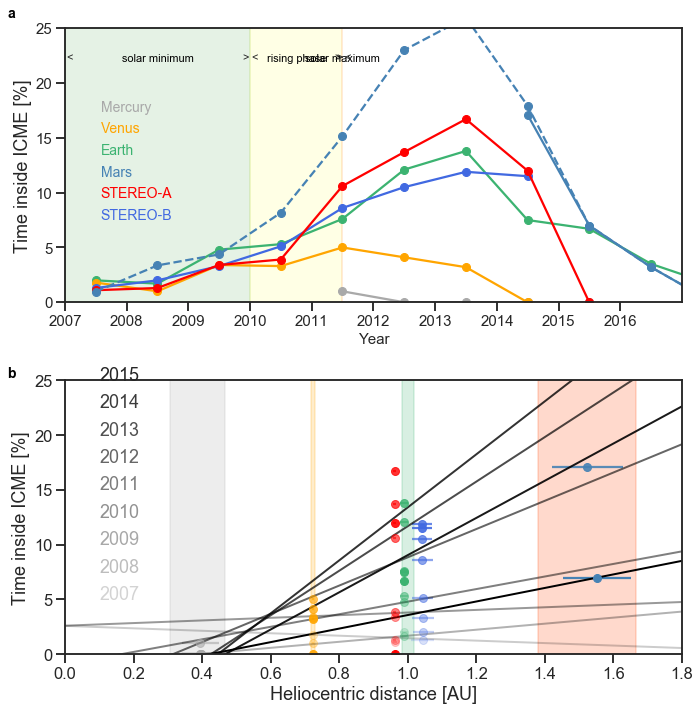



--------------------------------------------------


Time Inside

Mercury +/-
7.2
7.2
rise
14.3
max
0.0

Venus +/-
3.0
0.9
min
2.1
rise
4.2
max
2.8

Earth +/-
6.6
3.2
min
2.8
rise
6.3
max
10.6
MAVEN
nan



MAVEN results from 385 days of data, Dec 2014-Feb 2016, with gaps where no solar wind is available
MAVEN total days of observations with solar wind data:
385
MAVEN total ICME durations:
31.875416666666666
Mars is in percent of time inside ICMEs, for intervals in 2014-2016 (declining phase):
8.279329004329004
on average, Mars is hit by a CME every ... days
21.38888888888889
The ICME average duration is, in hours
42.50055555555556


<Figure size 432x288 with 0 Axes>

In [29]:
##################################### PLOT RESULTS ON TIME INSIDE


### fix that VEX MESSENGER impact frequency is less than 1 AU by multiplying with a factor of 1.5
#check exact values with frequency plot

#inside_vex_perc=inside_vex_perc*1.5
#inside_mes_perc=inside_mes_perc*1.5


sns.set_context("talk")     
sns.set_style("ticks",{'grid.linestyle': '--'})

fig=plt.figure(5,figsize=(10,10	))

ax1 = plt.subplot(211) 

plt.plot_date(yearly_mid_times,inside_win_perc,'o',color='mediumseagreen',markersize=8, linestyle='-')
plt.plot_date(yearly_mid_times,inside_merc_perc,'o',color='darkgrey',markersize=8,linestyle='-')
plt.plot_date(yearly_mid_times,inside_vex_perc,'o',color='orange',markersize=8,linestyle='-')
plt.plot_date(yearly_mid_times,inside_stb_perc,'o',color='royalblue',markersize=8,linestyle='-')
plt.plot_date(yearly_mid_times,inside_sta_perc,'o',color='red',markersize=8,linestyle='-')
plt.plot_date(yearly_mid_times,inside_mav_perc,'o',color='steelblue',markersize=8,linestyle='-')

plt.ylabel('Time inside ICME [%]')

#plt.xlim(yearly_bin_edges[0],yearly_bin_edges[10])
ax1.xaxis_date()
myformat = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(myformat)

#sets planet / spacecraft labels
xoff=0.15
yoff=0.85
fsize=14

plt.figtext(xoff,yoff-0.03*0,'Mercury',color='darkgrey', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*1,'Venus',color='orange', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*2,'Earth',color='mediumseagreen', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*3,'Mars',color='steelblue', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*4,'STEREO-A',color='red', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*5,'STEREO-B',color='royalblue', fontsize=fsize, ha='left')
#panel labels
plt.figtext(0.02,0.98,'a',color='black', fontsize=fsize, ha='left',fontweight='bold')
plt.figtext(0.02,0.48,'b',color='black', fontsize=fsize, ha='left',fontweight='bold')



#limits solar min/rise/max

vlevel=22
fsize=11

plt.axvspan(minstart_num,minend_num, color='green', alpha=0.1)
plt.annotate('solar minimum',xy=(minstart_num+(minend_num-minstart_num)/2,vlevel),color='black', ha='center', fontsize=fsize)
plt.annotate('<',xy=(minstart_num+10,vlevel),ha='left', fontsize=fsize)
plt.annotate('>',xy=(minend_num-10,vlevel),ha='right', fontsize=fsize)


plt.axvspan(risestart_num,riseend_num, color='yellow', alpha=0.1)
plt.annotate('rising phase',xy=(risestart_num+(riseend_num-risestart_num)/2,vlevel),color='black', ha='center', fontsize=fsize)
plt.annotate('<',xy=(risestart_num+10,vlevel),ha='left', fontsize=fsize)
plt.annotate('>',xy=(riseend_num-10,vlevel),ha='right', fontsize=fsize)

plt.axvspan(maxstart_num,maxstart_num, color='red', alpha=0.1)
plt.annotate('solar maximum',xy=(maxstart_num+(maxstart_num-maxstart_num)/2,vlevel),color='black', ha='center', fontsize=fsize)
plt.annotate('<',xy=(maxstart_num+10,vlevel),ha='left', fontsize=fsize)
plt.annotate('>',xy=(maxstart_num,vlevel),ha='right', fontsize=fsize)


plt.ylim((0,25))
fsize=15
plt.ylabel('Time inside ICME [%]')
plt.xlabel('Year',fontsize=fsize)
plt.yticks(fontsize=fsize) 
plt.xticks(fontsize=fsize) 


plt.tight_layout()



#plt.ylim(0,45)
plt.xlim(yearly_start_times[0],yearly_end_times[9])

#sns.despine()




#### plot time inside vs. heliocentric distance

pos_wind_perc=np.zeros(np.size(yearly_mid_times))
pos_wind_perc.fill(np.nan)
pos_wind_perc_std=np.zeros(np.size(yearly_mid_times))
pos_wind_perc_std.fill(np.nan)

pos_sta_perc=np.zeros(np.size(yearly_mid_times))
pos_sta_perc.fill(np.nan)
pos_sta_perc_std=np.zeros(np.size(yearly_mid_times))
pos_sta_perc_std.fill(np.nan)

pos_stb_perc=np.zeros(np.size(yearly_mid_times))
pos_stb_perc.fill(np.nan)
pos_stb_perc_std=np.zeros(np.size(yearly_mid_times))
pos_stb_perc_std.fill(np.nan)

#pos_mes_perc=np.zeros(np.size(yearly_mid_times))
#pos_mes_perc.fill(np.nan)
#pos_mes_perc_std=np.zeros(np.size(yearly_mid_times))
#pos_mes_perc_std.fill(np.nan)


pos_merc_perc=np.zeros(np.size(yearly_mid_times))
pos_merc_perc.fill(np.nan)
pos_merc_perc_std=np.zeros(np.size(yearly_mid_times))
pos_merc_perc_std.fill(np.nan)

pos_vex_perc=np.zeros(np.size(yearly_mid_times))
pos_vex_perc.fill(np.nan)
pos_vex_perc_std=np.zeros(np.size(yearly_mid_times))
pos_vex_perc_std.fill(np.nan)

pos_mav_perc=np.zeros(np.size(yearly_mid_times))
pos_mav_perc.fill(np.nan)
pos_mav_perc_std=np.zeros(np.size(yearly_mid_times))
pos_mav_perc_std.fill(np.nan)


allpositions=np.zeros([np.size(yearly_mid_times), 6])
allinside=np.zeros([np.size(yearly_mid_times), 6])

#calculate average distance +/- std for each year
#go through each year 
for i in range(np.size(yearly_mid_times)):
  
  #select those positions that are inside the current year
  thisyear=np.where(np.logical_and((pos_time_num > yearly_start_times[i]),(pos_time_num < yearly_end_times[i])))
  
  #pos_mes_perc[i]=np.mean(pos.messenger[0][thisyear])
  #pos_mes_perc_std[i]=np.std(pos.messenger[0][thisyear])
  pos_merc_perc[i]=np.mean(pos.mercury[0][thisyear])
  pos_merc_perc_std[i]=np.std(pos.mercury[0][thisyear])
  

  pos_mav_perc[i]=np.mean(pos.mars[0][thisyear])
  pos_mav_perc_std[i]=np.std(pos.mars[0][thisyear])

  pos_vex_perc[i]=np.mean(pos.venus[0][thisyear])
  pos_vex_perc_std[i]=np.std(pos.venus[0][thisyear])

  pos_wind_perc[i]=np.mean(pos.earth_l1[0][thisyear])
  pos_wind_perc_std[i]=np.std(pos.earth_l1[0][thisyear])

  pos_sta_perc[i]=np.mean(pos.sta[0][thisyear])
  pos_sta_perc_std[i]=np.std(pos.sta[0][thisyear])

  pos_stb_perc[i]=np.mean(pos.stb[0][thisyear])
  pos_stb_perc_std[i]=np.std(pos.stb[0][thisyear])
  
  allpositions[i][:]=(pos_merc_perc[i], pos_mav_perc[i], pos_vex_perc[i],pos_wind_perc[i],pos_sta_perc[i],pos_stb_perc[i])
  allinside[i][:]=(inside_merc_perc[i], inside_mav_perc[i], inside_vex_perc[i],inside_win_perc[i],inside_sta_perc[i],inside_stb_perc[i])
  
 
  



#***make alpha variable for each year?

ax3 = plt.subplot(212) 


#for every year linear fit **check if power law works better

#for fit plotting
xfit=np.linspace(0,2,1000)

#allpositions[i] and allinside[i] are the data for each year
#no fit for 2016 as only MAVEN data is available


for i in range(np.size(yearly_mid_times)-2):
 #make linear fits ignoring NaN
 notnan=np.where(np.isfinite(allinside[i]) > 0)
 durfit=np.polyfit(allpositions[i][notnan],allinside[i][notnan],1)
 #this is similar to D=durfit[0]*xfit+durfit[1]
 durfitfun=np.poly1d(durfit)
 print('year',i+2007)
 print('time inside linear fit: D[hours]={:.2f}r[AU]+{:.2f}'.format(durfit[0],durfit[1]))
 plt.plot(xfit,durfitfun(xfit),'-',color='black', lw=2, alpha=i/10+0.2)#,label='fit')
 
 plt.errorbar(pos_merc_perc[i], inside_merc_perc[i], xerr=pos_merc_perc_std[i],yerr=0,fmt='o',color='darkgrey',markersize=8,linestyle=' ',alpha=i/10+0.2)
 plt.errorbar(pos_mav_perc[i], inside_mav_perc[i],xerr=pos_mav_perc_std[i],fmt='o',color='steelblue',markersize=8,linestyle=' ',alpha=i/10+0.2)
 plt.errorbar(pos_sta_perc[i], inside_sta_perc[i],xerr=pos_sta_perc_std[i],fmt='o',color='red',markersize=8,linestyle=' ',alpha=i/10+0.2)
 plt.errorbar(pos_stb_perc[i], inside_stb_perc[i],xerr=pos_stb_perc_std[i],fmt='o',color='royalblue',markersize=8,linestyle=' ',alpha=i/10+0.2)
 plt.errorbar(pos_wind_perc[i], inside_win_perc[i],xerr=pos_wind_perc_std[i],fmt='o',color='mediumseagreen',markersize=8, linestyle=' ',alpha=i/10+0.2)
 plt.errorbar(pos_vex_perc[i], inside_vex_perc[i],xerr=pos_vex_perc_std[i],fmt='o',color='orange',markersize=8,linestyle=' ',alpha=i/10+0.2)
 
 plt.annotate(str(i+2007), xy=(0.1,5+2.5*i), alpha=i/10+0.2)
 
 
 #reconstruct Mars time inside from linear fits but not for years 2015 /2016
 if i < 8: inside_mav_perc[i]=durfitfun(pos_mav_perc[i])


#mars limits
plt.axvspan(np.min(pos.mars[0]),np.max(pos.mars[0]), color='orangered', alpha=0.2)
#plt.figtext(0.8,0.8,'Mars',color='orangered')
plt.axvspan(np.min(pos.mercury[0]),np.max(pos.mercury[0]), color='darkgrey', alpha=0.2)
#plt.figtext(0.25,0.8,'Mercury',color='darkgrey')
plt.axvspan(np.min(pos.venus[0]),np.max(pos.venus[0]), color='orange', alpha=0.2)
#plt.figtext(0.42,0.8,'Venus',color='orange')
plt.axvspan(np.min(pos.earth[0]),np.max(pos.earth[0]), color='mediumseagreen', alpha=0.2)
#plt.figtext(0.6,0.8,'Earth',color='mediumseagreen')
plt.xlim(0,1.8)

#solar probe plus 10 to 36 Rs close approaches

#plt.axvspan(Rs_in_AU*10,Rs_in_AU*36,color='magenta', alpha=0.2)

plt.ylabel('Time inside ICME [%]')
plt.xlabel('Heliocentric distance [AU]')
ax3.set_xticks(np.arange(0,2,0.2))

#add reconstructed Mars time inside on previous plot
ax1.plot_date(yearly_mid_times,inside_mav_perc,'o',color='steelblue',markersize=8,linestyle='--')


plt.ylim((0,25))

plt.tight_layout()

plt.show()
plt.savefig('results/plots_stats/time_inside_CMEs_paper.pdf', dpi=300)
plt.savefig('results/plots_stats/time_inside_CMEs_paper.png', dpi=300)





#TI

print()
print()
print('--------------------------------------------------')
print()
print()

print('Time Inside')

print()
print('Mercury +/-')
print(round(np.nanmean(inside_merc_cycle),1))
print(round(np.nanstd(inside_merc_cycle),1))
#print('min')
#print(round(inside_merc_cycle[0],1))
print('rise')
print(round(inside_merc_cycle[1],1))
print('max')
print(round(inside_merc_cycle[2],1))


print()
print('Venus +/-')
print(round(np.nanmean(inside_vex_cycle),1))
print(round(np.nanstd(inside_vex_cycle),1))
print('min')
print(round(inside_vex_cycle[0],1))
print('rise')
print(round(inside_vex_cycle[1],1))
print('max')
print(round(inside_vex_cycle[2],1))


print()
print('Earth +/-')
print(round(np.nanmean(inside_win_cycle),1))
print(round(np.nanstd(inside_win_cycle),1))
print('min')
print(round(inside_win_cycle[0],1))
print('rise')
print(round(inside_win_cycle[1],1))
print('max')
print(round(inside_win_cycle[2],1))


#only declining phase
print('MAVEN')
print(round(inside_mav_cycle[1],1))




###################### MAVEN

#from processing program
#all in days
totaldays=385 
total_icme_duration_maven=np.sum(ic.icme_duration[mavi])/24

print()
print()
print()


print('MAVEN results from 385 days of data, Dec 2014-Feb 2016, with gaps where no solar wind is available')
print('MAVEN total days of observations with solar wind data:')
print(totaldays)
print('MAVEN total ICME durations:')
print(total_icme_duration_maven)
print('Mars is in percent of time inside ICMEs, for intervals in 2014-2016 (declining phase):')
print(total_icme_duration_maven/totaldays*100)
print('on average, Mars is hit by a CME every ... days')
print(totaldays/np.size(mavi))
print('The ICME average duration is, in hours')
print(np.mean(ic.icme_duration[mavi]))


## 5. arrival frequencies in ICMECAT 


-------------------------------------------------
5 ARRIVAL FREQUENCY ICMECAT PLOT, 2 panels



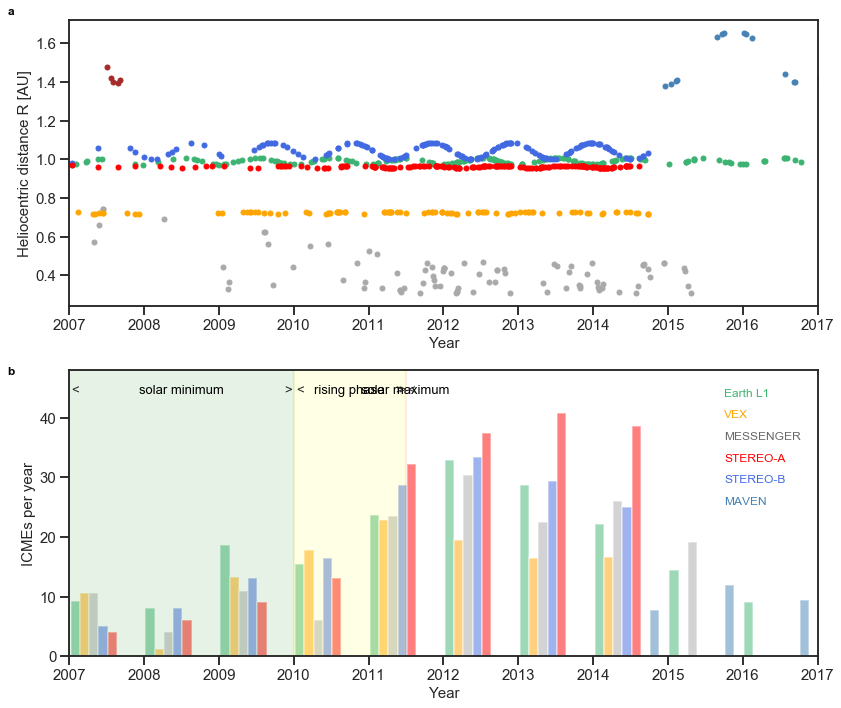

for solar min 2007-2009 average ICME per year rate:
8.82206358704523
for 2010 2011
20.00959295746026
for 2012 2013 2014
27.997187395550686
done


<Figure size 432x288 with 0 Axes>

In [31]:


print()
print('-------------------------------------------------')
print('5 ARRIVAL FREQUENCY ICMECAT PLOT, 2 panels')
print()


#define dates of January 1 from 2007 to 2017
years_jan_1_str=[str(i)+'-01-01' for i in np.arange(2007,2019) ] 
yearly_bin_edges=parse_time(years_jan_1_str).plot_date

#bin width in days         
binweite=360/8

sns.set_context("talk")     
sns.set_style("ticks",{'grid.linestyle': '--'})

fig=plt.figure(4,figsize=(12,10	))

fsize=15
ax1 = plt.subplot(211) 

plt.plot_date(ic.icme_start_time[wini],ic.mo_sc_heliodistance[wini],fmt='o',color='mediumseagreen',markersize=5)
plt.plot_date(ic.icme_start_time[mesi],ic.mo_sc_heliodistance[mesi],fmt='o',color='darkgrey',markersize=5)
plt.plot_date(ic.icme_start_time[vexi],ic.mo_sc_heliodistance[vexi],fmt='o',color='orange',markersize=5)
plt.plot_date(ic.icme_start_time[stbi],ic.mo_sc_heliodistance[stbi],fmt='o',color='royalblue',markersize=5)
plt.plot_date(ic.icme_start_time[stai],ic.mo_sc_heliodistance[stai],fmt='o',color='red',markersize=5)
plt.plot_date(ic.icme_start_time[ulyi],ic.mo_sc_heliodistance[ulyi],fmt='o',color='brown',markersize=5)
plt.plot_date(ic.icme_start_time[mavi],ic.mo_sc_heliodistance[mavi],fmt='o',color='steelblue',markersize=5)




fsize=15
plt.ylabel('Heliocentric distance R [AU]',fontsize=fsize)
plt.xlabel('Year',fontsize=fsize)
plt.yticks(fontsize=fsize) 
plt.xticks(fontsize=fsize) 


plt.xlim(yearly_bin_edges[0],yearly_bin_edges[10])
ax1.xaxis_date()
myformat = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(myformat)



##############

ax2 = plt.subplot(212) 

(histwin, bin_edgeswin) = np.histogram(mdates.date2num(ic.icme_start_time[wini]), yearly_bin_edges)
(histvex, bin_edgesvex) = np.histogram(mdates.date2num(ic.icme_start_time[vexi]), yearly_bin_edges)
(histmes, bin_edgesmes) = np.histogram(mdates.date2num(ic.icme_start_time[mesi]), yearly_bin_edges)
(histstb, bin_edgesstb) = np.histogram(mdates.date2num(ic.icme_start_time[stbi]), yearly_bin_edges)
(histsta, bin_edgessta) = np.histogram(mdates.date2num(ic.icme_start_time[stai]), yearly_bin_edges)
(histmav, bin_edgesmav) = np.histogram(mdates.date2num(ic.icme_start_time[mavi]), yearly_bin_edges)

#********
#recalculate number of ICMEs as events per month or day, including data gaps
'''
cycle_bin_edges=parse_time([minstart, minend, riseend, maxend]).plot_date

(histwincyc, bin_edgescyc) = np.histogram(mdates.date2num(ic.icme_start_time[wini]), cycle_bin_edges)
(histvexcyc, bin_edgescyc) = np.histogram(mdates.date2num(ic.icme_start_time[vexi]), cycle_bin_edges)
(histmescyc, bin_edgescyc) = np.histogram(mdates.date2num(ic.icme_start_time[mesi]), cycle_bin_edges)
(histstbcyc, bin_edgescyc) = np.histogram(mdates.date2num(ic.icme_start_time[stbi]), cycle_bin_edges)
(histstacyc, bin_edgescyc) = np.histogram(mdates.date2num(ic.icme_start_time[stai]), cycle_bin_edges)
(histmavcyc, bin_edgescyc) = np.histogram(mdates.date2num(ic.icme_start_time[mavi]), cycle_bin_edges)

#use total_data_days_vex etc. from previous plot 
histwincyc=histwincyc/total_data_days_win_cycle*365
histvexcyc=histvexcyc/total_data_days_vex_cycle*365
histmescyc=histmescyc/total_data_days_mes_cycle*365
histstbcyc=histstbcyc/total_data_days_stb_cycle*365
histstacyc=histstacyc/total_data_days_sta_cycle*365
histmavcyc=histmavcyc/total_data_days_mav_cycle*365
'''

#normalize each dataset for data gaps

histwin=histwin/total_data_days_yearly_win*365
histvex=histvex/total_data_days_yearly_vex*365
histmes=histmes/total_data_days_yearly_mes*365
histsta=histsta/total_data_days_yearly_sta*365
histstb=histstb/total_data_days_yearly_stb*365
histmav=histmav/total_data_days_yearly_mav*365

binedges=bin_edgeswin
pickle.dump([binedges,histwin,histvex,histmes,histsta,histstb,histmav], \
             open( "data/icme_frequency.p", "wb" ), protocol=2 )
#[binedges,histwin,histvex,histmes,histsta,histstb,histmav]=pickle.load( open( "plots_stats/stats/icme_frequency.p", "rb" ) )

#binweite=45
ax2.bar(bin_edgeswin[:-1]+30,histwin, width=binweite,color='mediumseagreen', alpha=0.5)
ax2.bar(bin_edgesvex[:-1]+30+binweite,histvex, width=binweite,color='orange', alpha=0.5)
ax2.bar(bin_edgesmes[:-1]+30+ binweite*2,histmes, width=binweite,color='darkgrey', alpha=0.5)
ax2.bar(bin_edgesstb[:-1]+30+binweite*3,histstb, width=binweite,color='royalblue', alpha=0.5)
ax2.bar(bin_edgessta[:-1]+30+binweite*4,histsta, width=binweite,color='red', alpha=0.5)
#ax2.bar(bin_edgessta[:-1]+30+binweite*5,histuly, width=binweite,color='brown', alpha=0.5)
ax2.bar(bin_edgesmav[:-1]+30+binweite*6,histmav, width=binweite,color='steelblue', alpha=0.5)

plt.xlim(yearly_bin_edges[0],yearly_bin_edges[10])
ax2.xaxis_date()
myformat = mdates.DateFormatter('%Y')
ax2.xaxis.set_major_formatter(myformat)
#sets planet / spacecraft labels
xoff=0.85
yoff=0.45
fsize=12
plt.figtext(xoff,yoff,'Earth L1',color='mediumseagreen', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*1,'VEX',color='orange', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*2,'MESSENGER',color='dimgrey', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*3,'STEREO-A',color='red', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*4,'STEREO-B',color='royalblue', fontsize=fsize, ha='left')
#plt.figtext(xoff,yoff-0.03*5,'Ulysses',color='brown', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*5,'MAVEN',color='steelblue', fontsize=fsize, ha='left')
#panel labels
plt.figtext(0.02,0.98,'a',color='black', fontsize=fsize, ha='left',fontweight='bold')
plt.figtext(0.02,0.48,'b',color='black', fontsize=fsize, ha='left',fontweight='bold')

plt.ylim(0,48)

#limits solar min/rise/max
vlevel=44
fsize=13

plt.axvspan(minstart_num,minend_num, color='green', alpha=0.1)
plt.annotate('solar minimum',xy=(minstart_num+(minend_num-minstart_num)/2,vlevel),color='black', ha='center', fontsize=fsize)
plt.annotate('<',xy=(minstart_num+10,vlevel),ha='left', fontsize=fsize)
plt.annotate('>',xy=(minend_num-10,vlevel),ha='right', fontsize=fsize)

plt.axvspan(risestart_num,riseend_num, color='yellow', alpha=0.1)
plt.annotate('rising phase',xy=(risestart_num+(riseend_num-risestart_num)/2,vlevel),color='black', ha='center', fontsize=fsize)
plt.annotate('<',xy=(risestart_num+10,vlevel),ha='left', fontsize=fsize)
plt.annotate('>',xy=(riseend_num-10,vlevel),ha='right', fontsize=fsize)

plt.axvspan(maxstart_num,maxstart_num, color='red', alpha=0.1)
plt.annotate('solar maximum',xy=(maxstart_num+(maxstart_num-maxstart_num)/2,vlevel),color='black', ha='center', fontsize=fsize)
plt.annotate('<',xy=(maxstart_num+10,vlevel),ha='left', fontsize=fsize)
plt.annotate('>',xy=(maxstart_num,vlevel),ha='right', fontsize=fsize)


fsize=15
plt.ylabel('ICMEs per year',fontsize=fsize)
plt.xlabel('Year',fontsize=fsize)
plt.yticks(fontsize=fsize) 
plt.xticks(fontsize=fsize) 


plt.tight_layout()

#sns.despine()
plt.show()
plt.savefig('results/plots_stats/ICME_frequency_paper.pdf', dpi=300)
plt.savefig('results/plots_stats/ICME_frequency_paper.png', dpi=300)







print('for solar min 2007-2009 average ICME per year rate:')
mean07=np.mean([histwin[0],histvex[0],histsta[0],histstb[0],histmes[0]])
mean08=np.mean([histwin[1],histvex[1],histsta[1],histstb[1],histmes[1]])
mean09=np.mean([histwin[2],histvex[2],histsta[2],histstb[2],histmes[2]])
print(np.nanmean([mean07,mean08,mean09]))

print('for 2010 2011')
mean10=np.mean([histwin[3],histvex[3],histsta[3],histstb[3],histmes[3]])
mean11=np.mean([histwin[4],histvex[4],histsta[4],histstb[4],histmes[4]])
print(np.mean([mean10,mean11]))


print('for 2012 2013 2014')
mean12=np.mean([histwin[5],histvex[5],histsta[5],histstb[5],histmes[5]])
mean13=np.mean([histwin[6],histvex[6],histsta[6],histstb[6],histmes[6]])
mean14=np.mean([histwin[7],histvex[7],histsta[7],histstb[7],histmes[7]])

print(np.mean([mean12,mean13,mean14]))







print('done')
############################################
